# Brain Tumor Classification with ResNet

## Setup

In [37]:
# import libraries

import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, makedirs
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import torch
from tqdm.notebook import tqdm
from torch import optim 
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split, TensorDataset

In [38]:
# settings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
plt.rcParams["figure.figsize"] = (10, 8)

## Data Preparation

### Image Preprocessing Functions

In [39]:
def crop_imgs(img_set, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in img_set:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


I have used different tranforms e.g. flips, rotations, brightness changes and etc from Keras ImageDataGenerator. I save the augmented data in augmented directory which will be automatically generated while running this notebook. 

In [40]:
def augment(img_set, dest_dir, num_replication):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest')

    for img in img_set:
        img = img.reshape((1,) + img.shape)
        count = 0
        for batch in data_gen.flow(x=img, batch_size=1, save_to_dir=dest_dir, save_format='jpg'):
            count += 1
            if count > num_replication:
                break

In [41]:
def plot_img(img, title=""):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title(title)

In [42]:
def read_imgs(file_dir):
    img_set = []
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        img_set.append(image)
    return img_set  

### Reading initial dataset

*Note*: tumor_dataset.zip file must be in the same directory as this notebook. 

In [21]:
# unzipping the dataset to yes and no directories
!unzip tumor_dataset.zip

Archive:  tumor_dataset.zip
replace no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [43]:
yes_img_set = read_imgs('yes')
no_img_set = read_imgs('no')

We can see that our initial dataset contains 155 positive images and 98 negative images. 

In [44]:
print("pos data count: ", len(yes_img_set))
print("neg data count: ", len(no_img_set))

pos data count:  155
neg data count:  98


### Examples

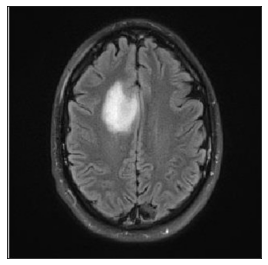

In [45]:
# Plotting an example image with tumor (Positive class)

plot_img(yes_img_set[22])

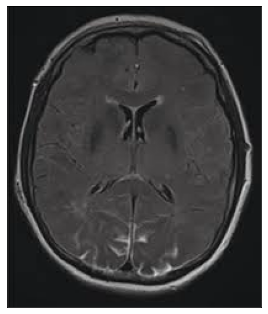

In [46]:
# Plotting an example image without tumor (Negative class)

plot_img(no_img_set[2])

### Cropping and Augmentation

In [47]:
# Cropping images 
yes_img_set_cropped = crop_imgs(yes_img_set)
no_img_set_cropped = crop_imgs(no_img_set)

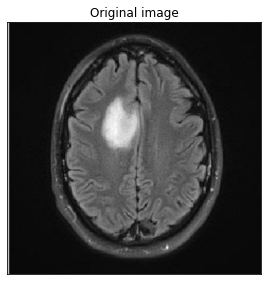

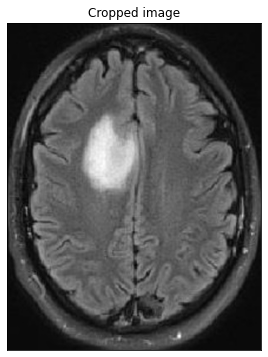

In [48]:
# An example of cropped images
plot_img(yes_img_set[22], "Original image")
plot_img(yes_img_set_cropped[22], "Cropped image")

In [51]:
# build augmented directories if it doesn't exist
try:
    makedirs('augmented/yes')
    makedirs('augmented/no')
except:
    pass    

In [52]:
# data augmentation
augment(yes_img_set_cropped, 'augmented/yes', 12)
augment(no_img_set_cropped, 'augmented/no', 15)

We can see that our augmented data contains about 3000 images with approximately equal percentage in each class.

In [53]:
num_yes = len(listdir('augmented/yes'))
num_no = len(listdir('augmented/no'))
    
print("Dataset Size:" , num_yes + num_no)
print("Positive samples num:", num_yes, ", Percentage:", num_yes/(num_yes + num_no) * 100)
print("Negative samples num:", num_no, ", Percentage:", num_no/(num_yes + num_no) * 100)

Dataset Size: 3231
Positive samples num: 1789 , Percentage: 55.36985453419994
Negative samples num: 1442 , Percentage: 44.63014546580006


In [54]:
# turn images to numpy array
def load_data(X, y, data_dir, target):
    for filename in listdir(data_dir):
        img = cv2.imread(data_dir + '/' + filename)
        img = cv2.resize(img, dsize=(240, 240))
        X.append([img[:, :, 0]])
        y.append(target)  
    return X, y

In [74]:
# loading data
X, y = [], []
X, y = load_data(X, y, 'augmented/yes', 1)
X, y = load_data(X, y, 'augmented/no', 0)
X = np.array(X)
y = np.array(y)
X, y = shuffle(X, y)

In [75]:
# Building tensors from data, splitting and creating datasets
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
print(y.shape)
data = TensorDataset(X, y)

t, v = int(len(data)*0.7), int(len(data)*0.1)
train_data, test_data = random_split(data, [t + v, len(data) - t - v])
train_data, val_data = random_split(train_data, [t, v])

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)

torch.Size([3231])


In [76]:
# A size test
for batch in train_loader:
  x, y = batch
  print(x.shape, y.shape)
  break

torch.Size([4, 1, 240, 240]) torch.Size([4])


I have splitted the data with 70%, 20% and 10% fractions for train, test and validation respectively.  

In [77]:
len(train_data), len(test_data), len(val_data)

(2261, 647, 323)

## Model

I have included the model code here but it is in resnet.py as an individual module. 

In [66]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, k, s, bn_flag, dp_flag):
        super(ResidualBlock, self).__init__()
        layers = []
        ds_layers = []
        layers += [nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding = (k-s+2)//2, bias=True)]
        if bn_flag:
          layers += [nn.BatchNorm2d(out_c)]   
        layers +=  [nn.ReLU()]
        if dp_flag:
          layers += [nn.Dropout(p = 0.3)]
        layers += [nn.Conv2d(out_c, out_c, kernel_size=k, stride=1, padding = (k-s+2)//2, bias=True)]
        if bn_flag:
          layers += [nn.BatchNorm2d(out_c)]  
        layers +=  [nn.ReLU()]
        if dp_flag:
          layers += [nn.Dropout(p = 0.3)]
        
        ds_layers += [nn.Conv2d(in_c, out_c, kernel_size=1, stride=s, padding=(1-s+2)//2, bias=True)]
        if bn_flag:
        RE    ds_layers += [nn.BatchNorm2d(out_c)]

        self.net = nn.Sequential(*layers)
        self.downsample = nn.Sequential(*ds_layers)

    def forward(self, x):
        o = self.net(x)
        o += self.downsample(x)
        return o

In [67]:
class ResNet(nn.Module):
    def __init__(self, num_classes, bn_flag, dp_flag):
        super(ResNet, self).__init__()
        self.block1 = ResidualBlock(in_c=1, out_c=8, k=7, s=3, bn_flag=bn_flag, dp_flag=dp_flag)
        self.block2 = ResidualBlock(in_c=8, out_c=16, k=5, s=3, bn_flag=bn_flag, dp_flag=dp_flag)
        self.block3 = ResidualBlock(in_c=16, out_c=32, k=3, s=3, bn_flag=bn_flag, dp_flag=dp_flag)
        self.fc = nn.Linear(2592 , num_classes, bias=True)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        o = self.block1(x) 
        o = self.block2(o)  
        o = self.block3(o)  
        o = o.view(-1, 2592) 
        o = self.fc(o)
        o = self.softmax(o)
        return o

## Training & Evaluation

In [82]:
# Training and evaluation functions

def train(model, t_loader, v_loader, criterion, optimizer, device, epochs):
    model.train()
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []
    for epoch in tqdm(range(epochs)):
        train_loss = []
        train_acc = []
        for x, y in t_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            train_loss.append(loss.item())
            _, predicted = torch.max(logits.data, 1)
            train_acc.append((predicted == y).sum().item() / y.size(0))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)
        val_loss, val_acc = evaluate(model, v_loader, criterion, device)
        log_train_loss.append(train_loss)
        log_train_acc.append(train_acc)
        log_val_loss.append(val_loss)
        log_val_acc.append(val_acc)
        print(epoch+1, ' train loss:', train_loss, ' -- train accuracy:', train_acc)
        print('   val loss:', val_loss, ' -- val accuracy:', val_acc)
    return log_train_loss, log_train_acc, log_val_loss, log_val_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    with torch.no_grad():
        val_loss = []
        val_acc = []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_loss.append(criterion(logits, y).item())
            val_acc.append((torch.argmax(logits.data, 1) == y).sum().item() / y.size(0))
        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)
        return val_loss, val_acc

### Loss and Accuracy Plots

In [71]:
# a function for plotting loss or accuracy metrics
def plot_metric(train_metric, val_metric, title):
    plt.figure()
    plt.plot(train_metric, label='Training ' + title)
    plt.plot(val_metric, label='Validation ' + title)
    plt.title(title)
    plt.legend()
    plt.show()

### Evaluation

In [128]:
# model with batch norm and drop out
best_net = ResNet(num_classes=2, bn_flag=True, dp_flag=True)
optimizer = optim.Adam(best_net.parameters(), lr=0.0001)

You can see the architecture of the model in the cell below. This model uses both dropout and batch normalization. 

In [129]:
best_net.to(device)

ResNet(
  (block1): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(3, 3), padding=(3, 3))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.3, inplace=False)
    )
    (downsample): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(3, 3))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Conv2d(16, 1

In [131]:
log_train_loss, log_train_acc, log_val_loss, log_val_acc = train(best_net, train_loader, val_loader, criterion, optimizer, device, 100)

1  train loss: 0.6459570828259202  -- train accuracy: 0.6280918727915195
   val loss: 0.6157614791098937  -- val accuracy: 0.6810699588477366
2  train loss: 0.5902343803075514  -- train accuracy: 0.7084805653710248
   val loss: 0.5739858864266195  -- val accuracy: 0.7366255144032922
3  train loss: 0.5478729928445479  -- train accuracy: 0.7623674911660777
   val loss: 0.5317187736063828  -- val accuracy: 0.7962962962962963
4  train loss: 0.5078879696952159  -- train accuracy: 0.8074204946996466
   val loss: 0.5143741921142295  -- val accuracy: 0.801440329218107
5  train loss: 0.469808658104482  -- train accuracy: 0.8462897526501767
   val loss: 0.5125122611169461  -- val accuracy: 0.7849794238683128
6  train loss: 0.43610337371329116  -- train accuracy: 0.8851590106007067
   val loss: 0.4489947929058546  -- val accuracy: 0.860082304526749
7  train loss: 0.4184657292631405  -- train accuracy: 0.8992932862190812
   val loss: 0.4489537293528333  -- val accuracy: 0.8641975308641975
8  train

We can see that our model converges fast and our test accuracy is about 87%. 

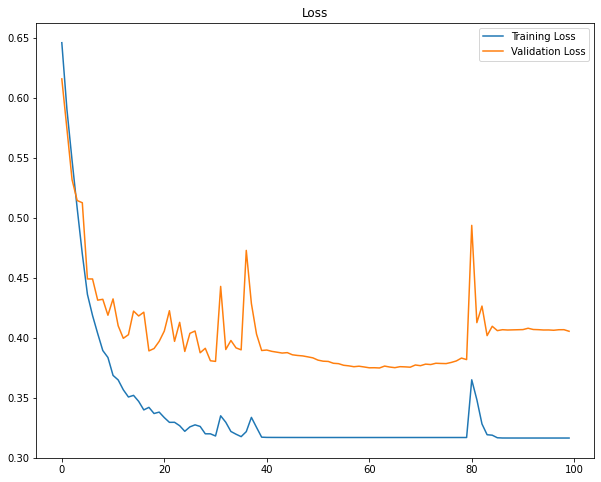

In [132]:
plot_metric(log_train_loss, log_val_loss, 'Loss')

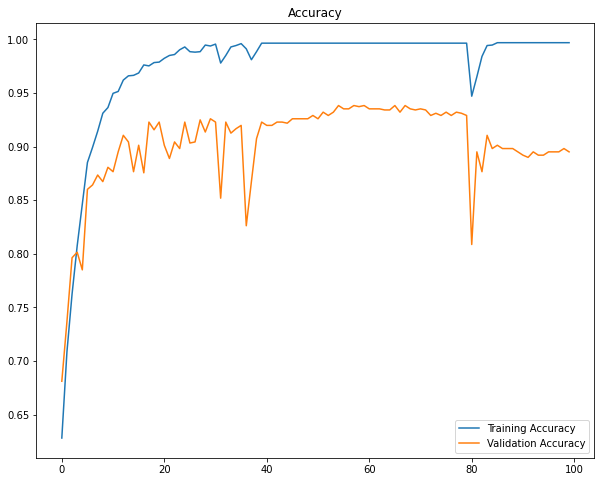

In [133]:
plot_metric(log_train_acc, log_val_acc, 'Accuracy')

In [87]:
 test_loss, test_acc = evaluate(best_net, test_loader, criterion, device)
 print("Test Accuracy: ", test_acc)

Test Accuracy:  0.8688271604938271


## Furthur investigation


### Effect of Batch Normalization

In [95]:
# model without batch norm
resnet_bn = ResNet(num_classes=2, bn_flag=False, dp_flag=True)
optimizer = optim.Adam(resnet_bn.parameters(), lr=0.00001)

In [96]:
resnet_bn.to(device)

ResNet(
  (block1): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(3, 3), padding=(3, 3))
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (4): ReLU()
      (5): Dropout(p=0.3, inplace=False)
    )
    (downsample): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(3, 3))
    )
  )
  (block2): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU()
      (5): Dropout(p=0.3, inplace=False)
    )
    (downsample): Sequential(
      (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(3, 3))
    )
  )
  (block3): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
      (1): ReLU

In [97]:
log_train_loss, log_train_acc, log_val_loss, log_val_acc = train(resnet_bn, train_loader, val_loader, criterion, optimizer, device, 100)

1  train loss: 0.8089269068447524  -- train accuracy: 0.48939929328621906
   val loss: 0.7513205747545502  -- val accuracy: 0.5524691358024691
2  train loss: 0.7667642770723404  -- train accuracy: 0.5432862190812721
   val loss: 0.7297886937488745  -- val accuracy: 0.5823045267489712
3  train loss: 0.7646143046790214  -- train accuracy: 0.5481448763250883
   val loss: 0.7311273706548008  -- val accuracy: 0.581275720164609
4  train loss: 0.7628809694371881  -- train accuracy: 0.5499116607773852
   val loss: 0.7314500010307924  -- val accuracy: 0.581275720164609
5  train loss: 0.761968783428728  -- train accuracy: 0.5512367491166078
   val loss: 0.7280321897547922  -- val accuracy: 0.5833333333333334
6  train loss: 0.7620603005688098  -- train accuracy: 0.5503533568904594
   val loss: 0.7287749913003709  -- val accuracy: 0.5853909465020576
7  train loss: 0.7608768180170665  -- train accuracy: 0.5525618374558304
   val loss: 0.7289881036605363  -- val accuracy: 0.5833333333333334
8  train

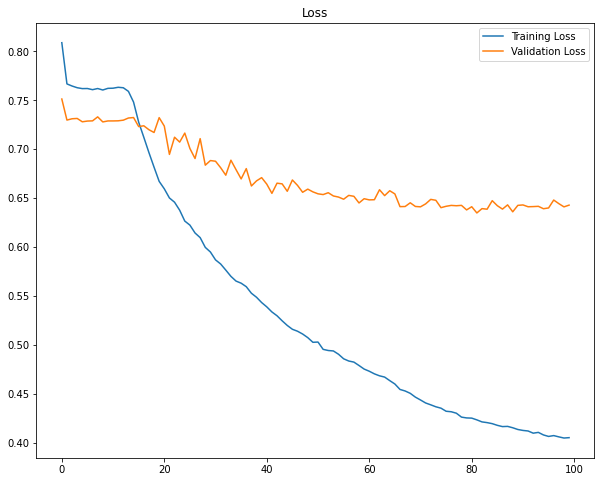

In [98]:
plot_metric(log_train_loss, log_val_loss, 'Loss')

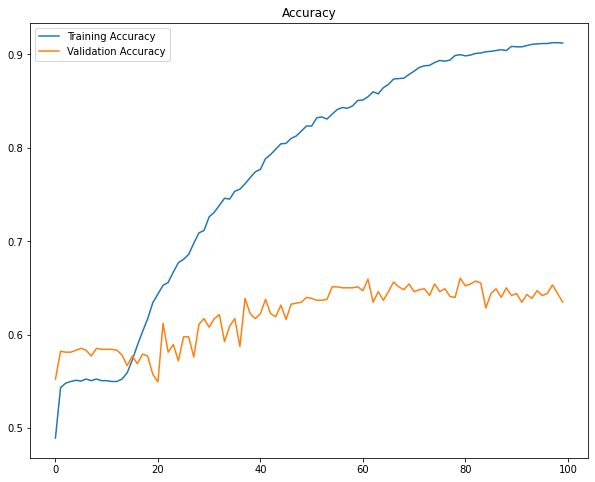

In [99]:
plot_metric(log_train_acc, log_val_acc, 'Accuracy')

In [100]:
 test_loss, test_acc = evaluate(resnet_bn, test_loader, criterion, device)
 print("Test Accuracy Without Batch Normalization: ", test_acc)

Test Accuracy Without Batch Normalization:  0.6666666666666666


**Explanations:**

We can see that the accuracy in our model without batch normalization is reduced by about 25%. This shows that batch normalization which is a technique of normalizing the layers by scaling and centering, is very effective in terms of performance and stability. Batch normalization normalizes the output of an activation layer by subtracting from its mean and dividing by its variance, as a result, it reduces the covariance shift. After that it denormalize (scale and shift) it by two trainable parameters gamma and beta. This lets SGD do the denormalization by changing only these two weights for each activation and therefore, the model will train faster and become more stable. We can see that our loss curve is smoother in the version using batch norm and also it converges faster. 

### Effect of Dropout

In [101]:
# model without dropout
resnet_dp = ResNet(num_classes=2, bn_flag=True, dp_flag=False)
optimizer = optim.Adam(resnet_dp.parameters(), lr=0.00001)

In [102]:
resnet_dp.to(device)

ResNet(
  (block1): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(3, 3), padding=(3, 3))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (downsample): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(3, 3))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac

In [104]:
log_train_loss, log_train_acc, log_val_loss, log_val_acc = train(resnet_dp, train_loader, val_loader, criterion, optimizer,  device, 100)

1  train loss: 0.6915439042417405  -- train accuracy: 0.556095406360424
   val loss: 0.6601914505899689  -- val accuracy: 0.6008230452674896
2  train loss: 0.6634745112893439  -- train accuracy: 0.6073321554770318
   val loss: 0.6447473208845398  -- val accuracy: 0.624485596707819
3  train loss: 0.6360880000115283  -- train accuracy: 0.6563604240282686
   val loss: 0.6265219181408117  -- val accuracy: 0.6584362139917695
4  train loss: 0.6131592589321911  -- train accuracy: 0.6992049469964664
   val loss: 0.6118981860302113  -- val accuracy: 0.7037037037037037
5  train loss: 0.5932038260011707  -- train accuracy: 0.7257067137809188
   val loss: 0.6038690477977564  -- val accuracy: 0.6923868312757202
6  train loss: 0.5753967502407809  -- train accuracy: 0.7517667844522968
   val loss: 0.5870473278157505  -- val accuracy: 0.7438271604938271
7  train loss: 0.5594423953509583  -- train accuracy: 0.7641342756183745
   val loss: 0.5799373862919984  -- val accuracy: 0.7417695473251029
8  train

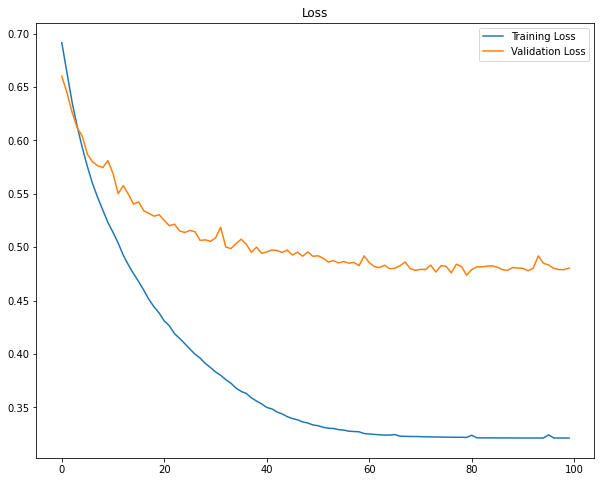

In [105]:
plot_metric(log_train_loss, log_val_loss, 'Loss')

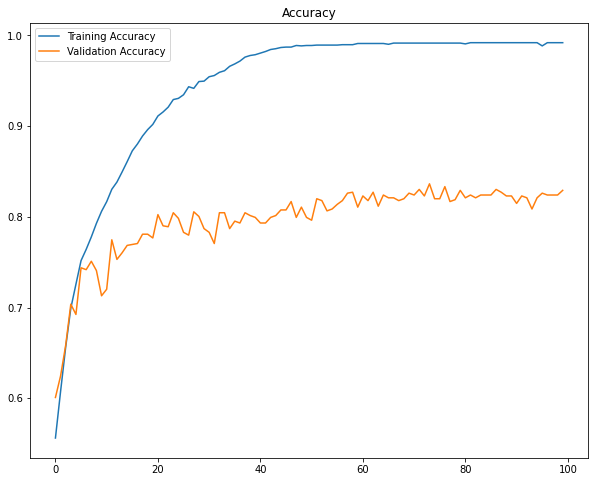

In [106]:
plot_metric(log_train_acc, log_val_acc, 'Accuracy')

In [107]:
 test_loss, test_acc = evaluate(resnet_dp, test_loader, criterion, device)
 print("Test Accuracy Without Dropout: ", test_acc)

Test Accuracy Without Dropout:  0.808641975308642


**Explanations:**

We can see that our accuracy without dropout is lower than the accuracy with dropout. Dropout is a regularization method that is used to combat overfitting in a network by randomly dropping out (temporarily removing) neurons. This makes a model with large weights less complex and can help it train faster and get a better accuracy. 

### Model without Batch norm and Droput

In [109]:
# model without dropout and batch norm
resnet_basic = ResNet(num_classes=2, bn_flag=False, dp_flag=False)
optimizer = optim.Adam(resnet_basic.parameters(), lr=0.00001)

In [110]:
resnet_basic.to(device)

ResNet(
  (block1): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(3, 3), padding=(3, 3))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (3): ReLU()
    )
    (downsample): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(3, 3))
    )
  )
  (block2): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
    )
    (downsample): Sequential(
      (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(3, 3))
    )
  )
  (block3): ResidualBlock(
    (net): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (downsample): Sequential(
      (0): Conv2d(16, 32, kern

In [111]:
log_train_loss, log_train_acc, log_val_loss, log_val_acc = train(resnet_basic, train_loader, val_loader, criterion, optimizer,  device, 100)

1  train loss: 0.750727875915096  -- train accuracy: 0.5335689045936396
   val loss: 0.741028070817759  -- val accuracy: 0.5493827160493827
2  train loss: 0.7282714512028037  -- train accuracy: 0.5613957597173145
   val loss: 0.7199320443618444  -- val accuracy: 0.5781893004115226
3  train loss: 0.7133214982364708  -- train accuracy: 0.5786219081272085
   val loss: 0.7069283933551224  -- val accuracy: 0.5915637860082305
4  train loss: 0.6937005561990367  -- train accuracy: 0.5984982332155477
   val loss: 0.7002165291780307  -- val accuracy: 0.5977366255144032
5  train loss: 0.6800395058658856  -- train accuracy: 0.6117491166077739
   val loss: 0.7175495127836863  -- val accuracy: 0.5709876543209876
6  train loss: 0.6663903256503095  -- train accuracy: 0.627208480565371
   val loss: 0.6928673452801175  -- val accuracy: 0.6049382716049383
7  train loss: 0.6543150504149312  -- train accuracy: 0.6395759717314488
   val loss: 0.6862299074361353  -- val accuracy: 0.602880658436214
8  train l

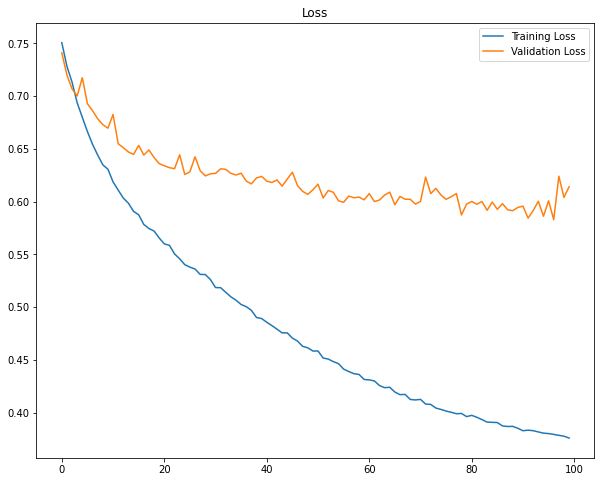

In [112]:
plot_metric(log_train_loss, log_val_loss, 'Loss')

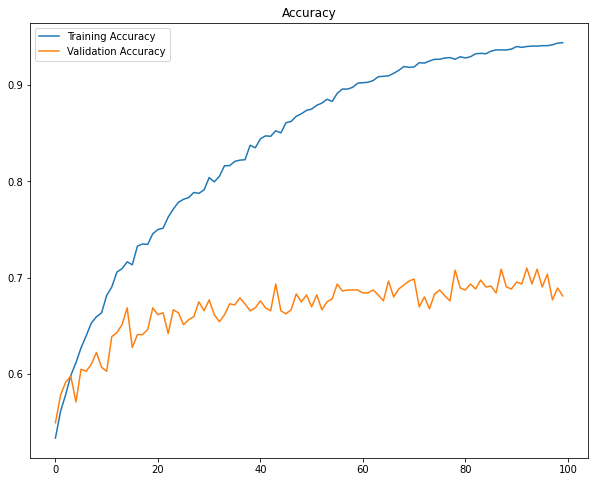

In [113]:
plot_metric(log_train_acc, log_val_acc, 'Accuracy')

In [114]:
 test_loss, test_acc = evaluate(resnet_basic, test_loader, criterion, device)
 print("Test Accuracy Without Dropout and Batch Normalization: ", test_acc)

Test Accuracy Without Dropout and Batch Normalization:  0.6882716049382716


## Visualization & Feature Maps

In [178]:
# Extracting convolutional layers

filters = [] 
convs = [] 
blocks = list(net.children())
block_num = 3

for i in range(block_num):
    layers = list(blocks[i].children())
    for j in range(len(layers[0])):
        if (type(layers[0][j])) == nn.Conv2d:
            convs.append(layers[0][j])
            filters.append(layers[0][j].weight)

In [179]:
# parameters of each convolutional layer
convs

[Conv2d(1, 8, kernel_size=(7, 7), stride=(3, 3), padding=(3, 3)),
 Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)),
 Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2)),
 Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [180]:
# size of each filter
[x.shape for x in filters]

[torch.Size([8, 1, 7, 7]),
 torch.Size([8, 8, 7, 7]),
 torch.Size([16, 8, 5, 5]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([32, 16, 3, 3]),
 torch.Size([32, 32, 3, 3])]

#### Feature Maps

In [290]:
def plot_feature_map(filters, title):
    plt.figure()
    for channel, f in enumerate(filters.cpu()):
        plt.subplot(len(filters)/8, 8, channel + 1)
        plt.axis('off')
        plt.imshow(f[0, :, :].detach(), cmap='gray')
    plt.title(title)
    plt.show()

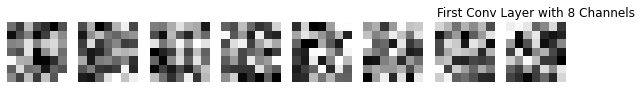

In [213]:
# first layer feature maps for 7 * 7 kernel
plot_feature_map(filters[0], 'First Conv Layer with 8 Channels')

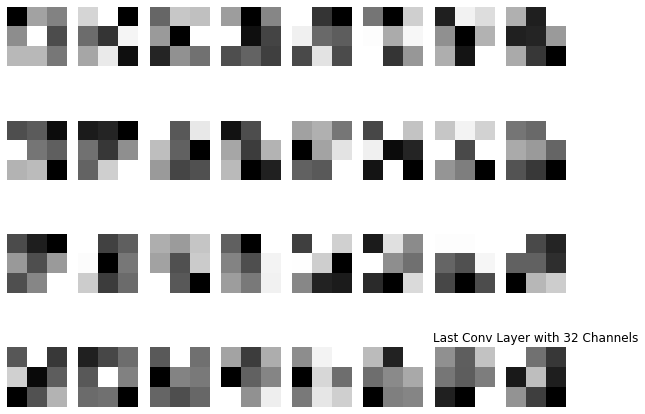

In [214]:
# last layer feature maps for 3 * 3 kernel
plot_feature_map(filters[len(filters) - 1], 'Last Conv Layer with 32 Channels')

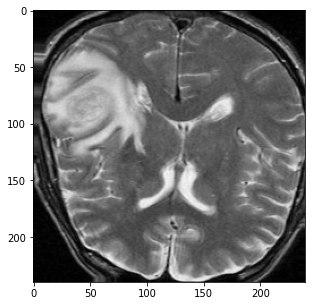

In [227]:
# Example image
plt.figure(figsize=(5, 5))
plt.imshow(train_data[0][0].cpu().numpy()[0], cmap='gray')

In [300]:
img = train_data[0][0][None, :, :, :]
print(img.shape)

torch.Size([1, 1, 240, 240])


torch.Size([8, 80, 80])
layer1 =================================


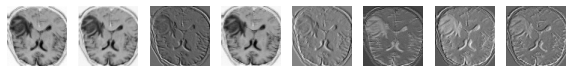

torch.Size([8, 80, 80])
layer2 =================================


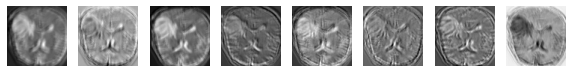

torch.Size([16, 27, 27])
layer3 =================================


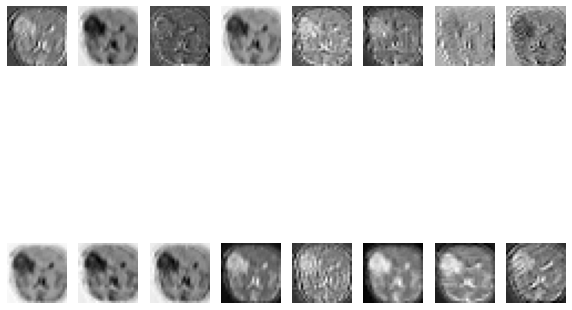

torch.Size([16, 27, 27])
layer4 =================================


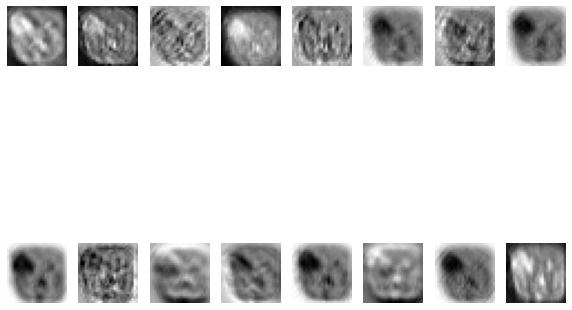

torch.Size([32, 9, 9])
layer5 =================================


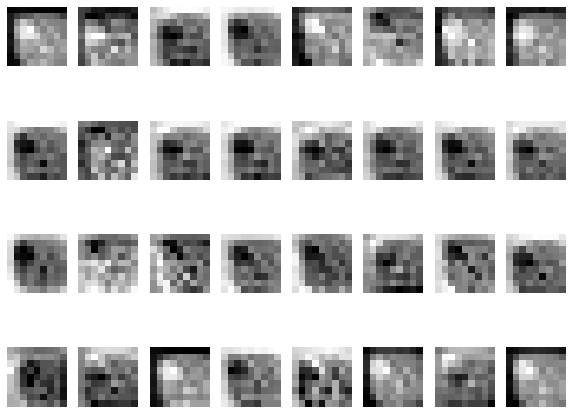

torch.Size([32, 9, 9])
layer6 =================================


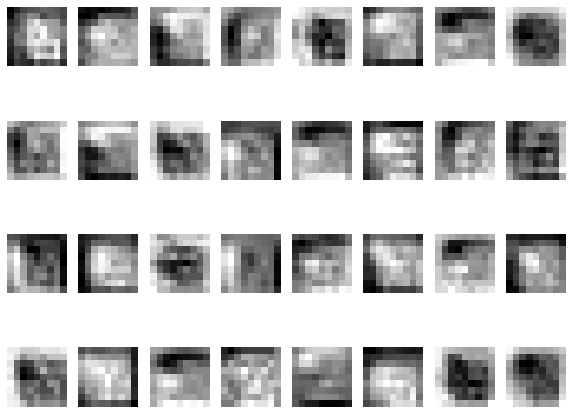

In [301]:
# passing the image through each conv layer  
for i in range(len(convs)):
    img = convs[i](img)
    print(img[0].shape)
    print('layer' + str(i+1) + ' =================================')
    plot_feature_map(img.data[0, :, None, :, :], "")

**Explanation:**

As these feature maps show, we can see that the early convolutional layers capture abstract features like borders and edges and colors, and as we go deeper into the network the conv layers capture high level features which are less easier for us to interpret. These high level features are used to interpret complex dependencies between different shapes in an image and enables the model to recognize its class.